In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime, pytz, sys
import influxdb_client, os, time
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

In [11]:
token = "XjJ1RcXCbFce1y747Htd_gsALsEcoeB72pbbUYMAf4C3RLdvQRIZJzraDzc_43cx0yQtsC9u5ikhOLNw2CiPig=="
token = 'c1naAAYSPJadt_jrVEuJLGqODdjn89P7kK-mSYcYtAPKesRgnF7mfRZNg6x7h_3Zzu3znV7Qwyj0-oeuTH83qQ=='
org = "SLACBL"
url = "http://localhost:8087"
local = pytz.timezone("America/Los_Angeles")

def db_dt(dt):
    return db_time(dt.year, dt.month, dt.day, dt.hour, dt.minute, int(dt.second))
def db_time(year,month,day,hour,minute,sec):
    dt = datetime.datetime(year,month,day,hour,minute,sec)
    dt_PT = local.localize(dt, is_dst=None)
    dt_utc = dt_PT.astimezone(pytz.utc)
    return datetime.datetime.strftime(dt_utc,"%Y-%m-%dT%H:%M:%SZ")

In [25]:
start_dt = datetime.datetime(2024,5,6,16,0,0)
end_dt   = datetime.datetime(2024,5,9,0,0,0)

# start_dt = datetime.datetime(2024,5,7,0,0,0)
# end_dt   = datetime.datetime(2024,5,7,1,0,0)


data = []
with InfluxDBClient(url="http://localhost:8086", token=token, org=org) as client:
    query = """from(bucket: "CryoLabData")
      |> range(start: %s, stop: %s)
      |> filter(fn: (r) => r["_measurement"] == "EC_Cham" or r["_measurement"] == "EC_Set" or r["_measurement"] == "EC_User" or r["_measurement"] == "LJT7_LNMass" or r["_measurement"] == "LJT_Resistance" or r["_measurement"] == "Electrometer")"""
    query = query%(db_dt(start_dt), db_dt(end_dt))
    tables = client.query_api().query(query, org=org)

    for table in tables:
        for record in table.records:
            data.append(np.array([record['_time'].astimezone(pytz.timezone("America/Los_Angeles")),\
                                  record['_measurement'],\
                                  record['_field'],\
                                  record["_value"] ]))
        
data_R = np.array(data)

In [26]:
data_R.shape

(259670, 4)

In [28]:
np.unique(data_R[:,1])

array(['EC_Cham', 'EC_Set', 'EC_User', 'LJT7_LNMass', 'LJT_Resistance'],
      dtype=object)

In [35]:
def convert_data_to_dict( data_array ):
    data_names = np.unique(data_array[:,1])
    
    output_dict = {}
    
    for name in data_names:
        mask = (data_R[:,1] == name)
        
        output_dict[name] = np.vstack((data_R[mask,0], data_R[mask,3]))

    return output_dict
    

In [37]:
output_dict = convert_data_to_dict( data_R )
output_dict.keys()

dict_keys(['EC_Cham', 'EC_Set', 'EC_User', 'LJT7_LNMass', 'LJT_Resistance'])

Text(0.5, 0, 'Time [hours]')

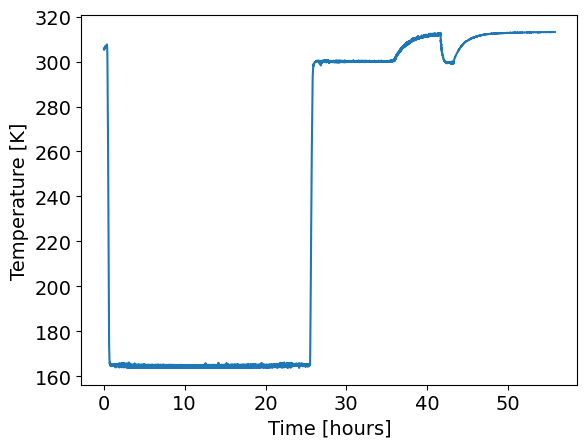

In [38]:
import matplotlib.dates as mdates

def ConvertDatesToHours( dates ):
    times_in_days = mdates.date2num( dates )
    return (times_in_days - times_in_days[0])*24

plt.rcParams['font.size'] = 14

plt.plot(ConvertDatesToHours(output_dict['EC_User'][0]),output_dict['EC_User'][1])
plt.ylabel('Temperature [K]')
plt.xlabel('Time [hours]')
# plt.savefig('resistance_vs_time_resistor_1.png',dpi=200,bbox_inches='tight')


# plt.figure(2)
# plt.plot(ConvertDatesToHours(data_temp[:,0]),data_temp[:,1])
# plt.ylabel('Temperature [K]')
# plt.xlabel('Time [hours]')
# plt.savefig('temperature_vs_time_resistor_1.png',dpi=200,bbox_inches='tight')

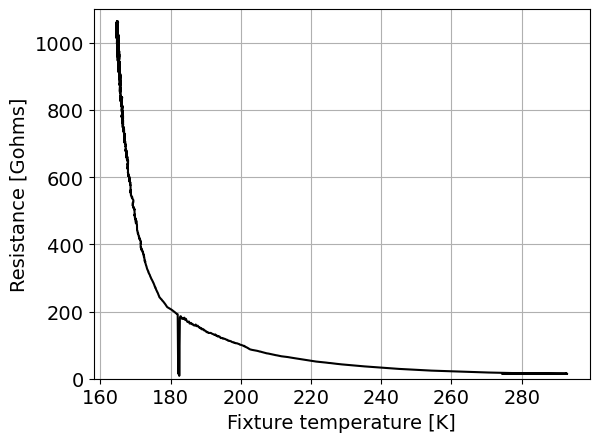

In [22]:
from scipy.interpolate import interp1d

fT = interp1d(ConvertDatesToHours(data_temp[:,0]),data_temp[:,1])
fR = interp1d(ConvertDatesToHours(data_R[:,0]),data_R[:,1]/1e9)

times = np.linspace(0.02,1.05,10000)

plt.plot(fT(times), fR(times), '-k',markersize=5)
plt.xlabel('Fixture temperature [K]')
plt.ylabel('Resistance [Gohms]')
plt.grid()
plt.ylim(0.,1100.)

plt.savefig('resistance_vs_USER_temperature_resistor_1.png',dpi=200,bbox_inches='tight')




/tmp/ipykernel_1295087/3285474236.py:2: RuntimeWarning: overflow encountered in exp
  return A*np.exp(-(x-x0)/tau ) + C


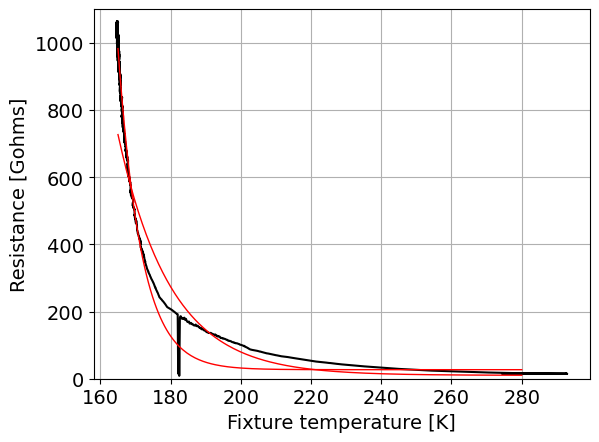

In [29]:
def ExpFit(x,A,x0,tau,C):
    return A*np.exp(-(x-x0)/tau ) + C

from scipy.optimize import curve_fit

p0 = (1000.,160.,15,10)

plt.figure(1)
plt.plot(fT(times), fR(times), '-k',markersize=5)
plt.xlabel('Fixture temperature [K]')
plt.ylabel('Resistance [Gohms]')
plt.grid()
plt.ylim(0.,1100.)
xguess = np.linspace(165.,280.,200)
yguess = ExpFit(xguess,*p0)
plt.plot(xguess,yguess,'-r',linewidth=1)

p,pcov = curve_fit(ExpFit, fT(times), fR(times), p0=p0)

plt.plot(xguess,ExpFit(xguess,*p),linewidth=1,color='r')


    